In [1]:
import argparse
from math import log10
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.cuda as cuda

import time
import numpy as np
import os
from RANet_lib import *
from RANet_lib.RANet_lib import *
from RANet_model import RANet as Net
import os
import os.path as osp
from glob import glob

import matplotlib.pyplot as plt
from torchvision import transforms
import PIL.Image as Image

In [ ]:
# params='RANet_video_multi.pth'
params='RANet_multi_retrained1_epoch1.pth'
dataset='17val'
save_root='../predictions/RANet_Video_17val'

net_name = 'RANet'
parser = argparse.ArgumentParser(description='RANet')
parser.add_argument('--deviceID', default=[0], help='device IDs')
parser.add_argument('--threads', type=int, default=16, help='number of threads for data loader to use')
parser.add_argument('--workfolder', default='../models/')
parser.add_argument('--savePName', default=net_name)
parser.add_argument('--net_type', default='single_object')
parser.add_argument('--fp16', default=True)
print('===> Setting ......')
# opt = parser.parse_args()
class args:
    pass
opt = args()
opt.deviceID = [0]
opt.threads=0
opt.workfolder='../models/'
opt.savePName = net_name
opt.net_type='single_object'
opt.fp16=False

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

try:
    os.mkdir(opt.workfolder)
    print('build working folder: ' + opt.workfolder)
except:
    print(opt.workfolder + 'exists')
print('using device ID: {}'.format(opt.deviceID))


print('===> Building model')
params='RANet_video_multi.pth'
dataset='17train'
save_root='../predictions/RANet_Video_17val'

model = Net(pretrained=False, type=opt.net_type)
model_cuda = None
inSize1 = 480
inSize2 = 864
if dataset in ['16val', '16trainval', '16all']:
    model.set_type('single_object')
    year = '2016'
elif dataset in ['17val', '17test_dev', '17train']:
    model.set_type('multi_object')
    year = '2017'
else:
    assert('dataset error')

DAVIS = dict(reading_type='SVOS',
                 year=year,
             root='../datasets/DAVIS/',
             subfolder=['', '', ''],
             mode=dataset,
             tar_mode='rep',
             train=0, val=0, test=0, predict=1,
             length=None,
             init_folder=None,
             )
dataset = DAVIS2017_loader(
    [DAVIS], mode='test',
    transform=[PAD_transform([inSize1, inSize2], random=False),
               PAD_transform([inSize1, inSize2], random=False)],
    rand=Rand_num())
checkpoint_load(opt.workfolder + params, model)

if opt.deviceID==[0]:
    model_cuda = model.cuda()
else:
    model_cuda = nn.DataParallel(model).cuda()
if opt.fp16:
    model_cuda = model_cuda.half()
    model_cuda.fp16 = True

# fitpredict17(dataset, model_cuda, add_name=add_name, threads=1, batchSize=1, save_root=save_root)

===> Setting ......
../models/exists
using device ID: [0]
===> Building model
Single-object mode
Change to multi-object mode
Number of files: 60
Dirs: 60


In [ ]:
checkpoint_load

In [ ]:
##### Arguments #####
data_set = dataset
model = model_cuda
add_name,threads,batchSize,save_root = '', 1, 1, save_root
##### Arguments #####

if data_set.Datasets_params[0]['mode'] in ['16val', '16all']:
    threshold = 0.5
    single_object = True
elif data_set.Datasets_params[0]['mode'] in ['17val', '17test_dev']:
    threshold = 0.5
    single_object = False
else:
    threshold = 0.5
    single_object = False
threads=0
print('Start testing ..., workers for dataloader:',threads,'batch size:', batchSize)
data_set.iter_mode = 'train'
data_loader = DataLoader(dataset=data_set, num_workers=threads, batch_size=batchSize, shuffle=False, pin_memory=True)
model.eval()
if not (os.path.exists(save_root)):
    os.mkdir(save_root)

train_batch

In [5]:
data_loader = data_loader
model=model
save_root=save_root
threshold=threshold
single_object=single_object
pre_first_frame=False
add_name=''


ms = [864, 480]
palette_path = '../datasets/palette.txt'
with open(palette_path) as f:
    palette = f.readlines()
palette = list(np.asarray([[int(p) for p in pal[0:-1].split(' ')] for pal in palette]).reshape(768))
def init_Frame(batchsize):
    Key_features = [[] for i in range(batchsize)]
    Masks = [[] for i in range(batchsize)]
    Init_Key_masks = [[] for i in range(batchsize)]
    Frames = [[] for i in range(batchsize)]
    Box = [[] for i in range(batchsize)]
    Image_names = [[] for i in range(batchsize)]
    Img_sizes = [[] for i in range(batchsize)]
    Frames_batch = dict(Frames=Frames, Key_features=Key_features, Masks=Masks, Box=Box, Img_sizes=Img_sizes, Init_Key_masks=Init_Key_masks,
                        Image_names=Image_names, Sizes=[0 for i in range(batchsize + 1)], batchsize=batchsize, Flags=[[] for i in range(batchsize)],
                        Img_flags=[[] for i in range(batchsize)])
    return Frames_batch
batchsize = 1
max_iter = batchsize
torch.set_grad_enabled(False)
_ = None
Frames_batch = init_Frame(batchsize)
print('Loading Data .........')

Loading Data .........


In [7]:
def custom_BCELoss(prediction, target):
    eps = 0.000001
    ratios = torch.clamp( ((1-target).sum(dim=1)/target.sum(dim=1)).reshape(-1,1), 1/100, 100)
    loss = -( ratios*target*torch.log(prediction + eps) +\
         (1-target)*torch.log(1-prediction + eps)).mean()
    return loss
def custom_BCELoss_with_logits(prediction, target):
    eps = 0
    ratios = torch.clamp( ((1-target).sum(dim=1)/target.sum(dim=1)).reshape(-1,1), 1/100, 100)
    loss = -( ratios*target*F.logsigmoid(prediction + eps) +\
         (1-target)*F.logsigmoid(-prediction + eps)).mean()
    return loss


In [8]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_per_epoch = []

In [9]:

for epoch in range(1):
    start_time = time.perf_counter()
    loss_per_batch = []
    for iteration, batch in enumerate(data_loader, 1):
        if (iteration < 7):
            continue
        if model.fp16:
            batch[0] = [datas.half() for datas in batch[0]]
            batch[1] = [datas.half() for datas in batch[1]]
        else:
            batch[0] = [datas for datas in batch[0]]
            batch[1] = [datas for datas in batch[1]]
        frame_num = len(batch[0])
        size = batch[0][0].size()[2::]
        # cc for key frame
        Frames = batch[0]
        Img_sizes = batch[3]

        loc = np.argmin(Frames_batch['Sizes'][0:batchsize])
        Fsize = len(batch[2])
        # print(loc)
        # print(Fsize)
        Frames_batch['Frames'][loc].extend(batch[0])
        Frames_batch['Masks'][loc].extend(batch[1])
        Frames_batch['Sizes'][loc] += Fsize 

        if iteration % max_iter == 0 or iteration == len(data_loader):
            print("Got first batch of images for training, iteration:", iteration,\
                  "time diff now:", time.perf_counter()-start_time)
        else : 
            continue
        ########### Once we have a whole minibatch of videos, train the network
        print("Gonna start training model")
        start_time_model = time.perf_counter()
        loss_per_mini_batch = []
        for idx in range(max(Frames_batch['Sizes'])):
            optimizer.zero_grad()
            torch.cuda.empty_cache()

            template = [[] for i in range(batchsize)]
            target = [[] for i in range(batchsize)]
            template_mask = [[] for i in range(batchsize)]
            target_mask = [[] for i in range(batchsize)]
            
            for batch_id, (frame2, mask2, frame1, mask1) in enumerate(\
                    zip([i[idx%(len(i)-1)] for i in Frames_batch['Frames']],\
                        [i[idx%(len(i)-1)] for i in Frames_batch['Masks']],\
                        [i[idx%(len(i)-1) +1] for i in Frames_batch['Frames']],\
                        [i[idx%(len(i)-1) +1] for i in Frames_batch['Masks']])):
                template[batch_id] = frame2
                template_mask[batch_id] = mask2
                target[batch_id] = frame1
                target_mask[batch_id] = mask1

            template = torch.cat(template,dim=0)
            template_mask = torch.cat(template_mask)
            target = torch.cat(target)
            target_mask = torch.cat(target_mask)
            
            template = template.cuda()
            template_mask = template_mask.cuda()
            target = target.cuda()
            target_mask = target_mask.cuda()
            print("max targets:", target_mask.max())
        #     with torch.no_grad():
            with torch.enable_grad():
                Out, corr_loss_batch = model.RANet_Multiple_forward_train(template=template,target=target,\
                                                template_msk=template_mask, target_msk = target_mask)
                prediction_single_masks = []
                target_single_masks = []
                for idx in range(len(Out)):
                    max_obj = template_mask[idx,0].max().int().data.cpu().numpy()
                    target_msk_images = model.P2masks(F.relu(target_mask[idx,0] - 1), max_obj - 1)
                    for i in range(max_obj-1):
                        prediction_single_masks.append(Out[idx][0,i].reshape(-1))
                        target_single_masks.append(target_msk_images[i+1].reshape(-1))


                prediction_single_masks = torch.stack(prediction_single_masks)
                target_single_masks = torch.stack(target_single_masks)

                cls_loss = custom_BCELoss_with_logits(prediction_single_masks,target_single_masks)
                lamda1= 0.5
                lamda2 = 0.5
                lamda = 0.001
                correlation_loss = 0
                count = 0
                for idx in range(len(corr_loss_batch)):  
                    template_FB_FB_loss = 0
                    template_FB_BG_loss = 0
                    target_FB_FB_loss = 0
                    target_FB_BG_loss = 0
                    tt_FB_FB_loss = 0
                    tt_FB_BG_loss = 0
                    for idy in range(len(corr_loss_batch[idx])):
                        template_FB_FB_loss += corr_loss_batch[idx][idy]['template_FB_FB_loss']
                        template_FB_BG_loss += corr_loss_batch[idx][idy]['template_FB_BG_loss']
                        target_FB_FB_loss += corr_loss_batch[idx][idy]['target_FB_FB_loss']
                        target_FB_BG_loss += corr_loss_batch[idx][idy]['target_FB_BG_loss']
                        tt_FB_FB_loss += corr_loss_batch[idx][idy]['tt_FB_FB_loss']
                        tt_FB_BG_loss += corr_loss_batch[idx][idy]['tt_FB_BG_loss']
                        count += 1

                    correlation_loss += lamda1*(template_FB_FB_loss+target_FB_FB_loss+tt_FB_FB_loss)/3 +\
                                    lamda2*(template_FB_BG_loss+target_FB_BG_loss+tt_FB_BG_loss)/3
                correlation_loss  = correlation_loss/count 
                total_loss = cls_loss + lamda*correlation_loss
            
            if np.isnan(total_loss.item()):
                print("Nan value for loss!, breaking")
                asdsad
            total_loss.backward()
            optimizer.step()
            loss_per_mini_batch.append([total_loss.item(), cls_loss.item(),correlation_loss.item() ])
            del total_loss, correlation_loss, cls_loss, Out, corr_loss_batch,\
                    template, target, template_mask, target_mask
        ######### Reinitialize Frames for the next set of videos
        Frames_batch = init_Frame(batchsize)
        loss_per_mini_batch = np.array(loss_per_mini_batch)
        loss_per_batch.append(loss_per_mini_batch.mean())
        end_time_model = time.perf_counter()
        memory = cuda.memory_allocated(0) /(1024*1024)
        print("Time to train model:", end_time_model - start_time_model,\
              "Total Time for one batch video:", end_time_model-start_time, "memory used",memory)
        checkpoint_save(opt.workfolder + 'RANet_multi_retrained1', 1, model)
        asds
    loss_per_epoch.append(np.mean(loss_per_batch))


Got first batch of images for training, iteration: 8 time diff now: 278.7771303448826
Gonna start training model
max targets: tensor(3., device='cuda:0')


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: tensor(3., device='cuda:0')
max targets: ten

RuntimeError: CUDA out of memory. Tried to allocate 10.12 MiB (GPU 0; 10.92 GiB total capacity; 9.34 GiB already allocated; 5.50 MiB free; 115.11 MiB cached)

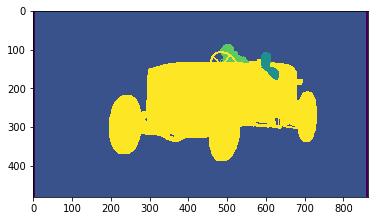

In [17]:
plt.imshow(target_mask[0,0].detach().cpu().numpy())

In [18]:
target_mask.shape

torch.Size([2, 1, 480, 864])

In [24]:
Frames_batch['Image_names']

[['../datasets/DAVIS/JPEGImages/480p/classic-car/00000.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00001.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00002.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00003.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00004.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00005.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00006.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00007.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00008.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00009.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00010.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00011.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00012.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00013.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00014.jpg',
  '../datasets/DAVIS/JPEGImages/480p/classic-car/00015.jpg',
  '../datasets/DAVIS/JPE

In [23]:
target_mask.max()

tensor(4., device='cuda:0')

In [18]:
optimizer.zero_grad()
torch.cuda.empty_cache()

cuda.memory_allocated(0) /(1024*1024)

9565.51806640625

In [15]:
import torch.nn.functional as f
self=model
template=template
target=target
template_msk=template_mask
target_msk = target_mask

In [16]:
base_features2 = self.res_forward(template)
Kernel_3 = f.normalize(f.max_pool2d(self.L3(base_features2[2]), 2))
Kernel_4 = f.normalize(self.L4(base_features2[3]))
Kernel_5 = f.normalize(f.interpolate(self.L5(base_features2[4]), scale_factor=2, mode='bilinear'))
Kernel_tmp = f.normalize(self.L_g(torch.cat([Kernel_3, Kernel_4, Kernel_5], dim=1)))
Kernel = Kernel_tmp

# Current frame feature
base_features1 = self.res_forward(target)
Feature_3 = f.normalize(f.max_pool2d(self.L3(base_features1[2]), 2))
Feature_4 = f.normalize(self.L4(base_features1[3]))
Feature_5 = f.normalize(f.interpolate(self.L5(base_features1[4]), scale_factor=2, mode='bilinear'))
Feature = f.normalize(self.L_g(torch.cat([Feature_3, Feature_4, Feature_5], dim=1)))

Out_Rs = []

basef1 = torch.cat([self.ls13(base_features1[2]),
                    self.ls14(base_features1[3]),
                    self.ls15(base_features1[4]), ], 1)
basef2 = torch.cat([self.ls22(base_features1[1]),
                    self.ls23(base_features1[2]),
                    self.ls24(base_features1[3]), ], 1)
basef3 = torch.cat([self.ls31(base_features1[0]),
                    self.ls32(base_features1[1]),
                    self.ls33(base_features1[2])], 1)
loss_per_batch = []
for idx in range(len(Feature)):  # batch
    ker = Kernel_tmp[idx: idx + 1]
    feature = Feature[idx: idx + 1]
    m2 = template_msk[idx: idx + 1]
    m1 = target_msk[idx: idx + 1]

    max_obj = m2.max().int().data.cpu().numpy()
    if max_obj < 2:
        m2[0, 0, 0, 0] = 2
        max_obj = m2.max().int().data.cpu().numpy()
    M2s = self.P2masks(f.relu(m2 - 1), max_obj - 1)
    M2_all = m2.ge(1.5).float()
    M1s = self.P2masks(f.relu(m1 - 1), max_obj - 1)
    M1_all = m1.ge(1.5).float()

    # Correlation
    W0, H0 = ker.size()[-2::]
    W,H = feature.size()[-2::]
    Corr_subs = []
    ker_R = self.to_kernel(ker)
    corr_R = self.correlate(ker_R, feature)

    template_self_corr = self.correlate(ker_R, ker)
    target_self_corr = self.correlate(self.to_kernel(feature), feature)

    # Ranking attention scores
    T_corr =  f.max_pool2d(corr_R,2).view(-1, W0*H0, W*H//4).transpose(1, 2).view(-1, W*H//4, W0, H0)
    R_map = f.relu(self.Ranking(T_corr)) * 0.2
    Rmaps = []


    for idy in range(max_obj):  # make corrs (backgrounds(=1) and objs)
        m2_rep = f.adaptive_avg_pool2d(M2s[idy], ker.size()[-2::])
        corr_sub = m2_rep.view(m2_rep.size()[0], -1, 1, 1) * corr_R
        Corr_subs.append(corr_sub)
        Rmaps.append((R_map * m2_rep).view(-1, 1, W0*H0))

    Outs = []
    loss_per_obj = []
    for idy in range(1, max_obj):  # training:with_bg, testing: w/o BG
        corr = Corr_subs[idy]
        co_size = Corr_subs[idy].size()[2::]
        max_only, indices = f.max_pool2d(corr, co_size, return_indices=True)
        max_only = max_only.view(-1, 1, W0*H0) + Rmaps[idy]

        #### For FG, adjust scores based on how close a pixel is to rest of the FG pixes and far away from BG pixels
        # Self correlation is of size: batch_size x W*H x W x H
        # We want the final score to be a score on each pixel and thus of dimension: batch_size x W*H x 1 x 1
        # Notation meaning: FG_BG: For WxH map with FG pixels, the channels have non zerovalue where 
        #                   channel id corresponds to BG != 0
        m2_rep = f.adaptive_avg_pool2d(M2s[idy], ker.size()[-2::])

        FG_FG = []
        FG_BG = []
        BG_BG = []
        BG_FG = []
        for b_iter in range(m2_rep.shape[0]):
            FG_FG.append(self.correlate(m2_rep[b_iter].view(-1, 1, 1, 1),m2_rep[b_iter:b_iter+1]))
            FG_BG.append(self.correlate(1-m2_rep[b_iter].view(-1, 1, 1, 1),m2_rep[b_iter:b_iter+1]))
            BG_FG.append(self.correlate(m2_rep[b_iter].view(-1, 1, 1, 1), 1-m2_rep[b_iter:b_iter+1]))
            BG_BG.append(self.correlate(1-m2_rep[b_iter].view(-1, 1, 1, 1),1-m2_rep[b_iter:b_iter+1]))
        FG_FG = torch.cat(FG_FG,dim=0)
        FG_BG = torch.cat(FG_BG,dim=0)
        BG_FG = torch.cat(BG_FG,dim=0)
        BG_BG = torch.cat(BG_BG,dim=0)

        ############# Loss for adjusting feature extractor
        loss_obj_dict = {}

        ######### For each FG pixel, find closest 5 pixels in FG and sum them up. That is the -ve loss for FG-FG
        num_pixels= 5
        ############################## Just template frame
        m2_rep_pos = m2_rep.ge(0.5).float()
        m2_rep_neg = m2_rep.le(0).float()
        if (self.fp16):
            m2_rep_pos = m2_rep_pos.half()
            m2_rep_neg = m2_rep_pos.half()
        indices = torch.nonzero(m2_rep_pos.reshape(-1))
        if (len(indices)>0):

            FB_FB_loss = (template_self_corr*m2_rep_pos).reshape(-1,W0*H0,W0*H0)
            FB_FB_loss, _ = FB_FB_loss.sort(descending=True, dim=2)
            FB_FB_loss = torch.cat([FB_FB_loss[:,index,:num_pixels] for index in indices], dim=1)

            FB_BG_loss = (template_self_corr*m2_rep_neg).reshape(-1,W0*H0,W0*H0)
            FB_BG_loss, _ = FB_BG_loss.sort(descending=True, dim=2)
            FB_BG_loss = torch.cat([FB_BG_loss[:,index,:num_pixels] for index in indices], dim=1)

            FB_FB_loss = FB_FB_loss.sum()/(len(indices)*num_pixels)
            FB_BG_loss = FB_BG_loss.sum()/(len(indices)*num_pixels)
        else:
            FB_FB_loss = 0
            FB_BG_loss = 0

        loss_obj_dict['template_FB_FB_loss'] = -FB_FB_loss
        loss_obj_dict['template_FB_BG_loss'] = FB_BG_loss

        ############################## Just target frame
        m1_rep = f.adaptive_avg_pool2d(M1s[idy], ker.size()[-2::])
        m1_rep_pos = m1_rep.ge(0.5).float()
        m1_rep_neg = m1_rep.le(0).float()
        if (self.fp16):
            m1_rep_pos = m1_rep_pos.half()
            m1_rep_neg = m1_rep_pos.half()
        indices = torch.nonzero(m1_rep_pos.reshape(-1))
        if (len(indices)>0):

            FB_FB_loss = (target_self_corr*m1_rep_pos).reshape(-1,W*H,W*H)
            FB_FB_loss, _ = FB_FB_loss.sort(descending=True, dim=2)
            FB_FB_loss = torch.cat([FB_FB_loss[:,index,:num_pixels] for index in indices], dim=1)

            FB_BG_loss = (target_self_corr*m1_rep_neg).reshape(-1,W*H,W*H)
            FB_BG_loss, _ = FB_BG_loss.sort(descending=True, dim=2)
            FB_BG_loss = torch.cat([FB_BG_loss[:,index,:num_pixels] for index in indices], dim=1)

            FB_FB_loss = FB_FB_loss.sum()/(len(indices)*num_pixels)
            FB_BG_loss = FB_BG_loss.sum()/(len(indices)*num_pixels)
        else :
            FB_FB_loss = 0
            FB_BG_loss = 0

        loss_obj_dict['target_FB_FB_loss'] = -FB_FB_loss
        loss_obj_dict['target_FB_BG_loss'] = FB_BG_loss

        ############################## Between template and target

        #### Between FG of template and FG of target
        # corr_R is of shape: batch_size x W0*H0 x W x H

        # We want FG of both to be close and FG-BG of both to be far
        FB_FB_loss = (corr_R*m1_rep_pos).reshape(-1,W0*H0,W*H)
        indices1 = torch.nonzero(m1_rep_pos.reshape(-1))
        indices2 = torch.nonzero(m2_rep_pos.reshape(-1))
        corr_R_transpose = corr_R.view(-1, W0*H0, W*H).transpose(1, 2).view(-1, W*H, W0, H0)

        if (len(indices1)>0):
            FB_FB_loss1, _ = FB_FB_loss.squeeze().transpose(0,1).sort(descending=True, dim=1)
            FB_FB_loss1 = torch.cat([FB_FB_loss1[index,:num_pixels] for index in indices1], dim=0)
            FB_FB_loss1 = FB_FB_loss1.sum()/(len(indices1)*num_pixels)

            FB_BG_loss1 = (corr_R_transpose*m1_rep_neg).reshape(-1,W*H,W0*H0)
            FB_BG_loss1, _ = FB_BG_loss1.squeeze().sort(descending=True, dim=1)
            FB_BG_loss1 = torch.cat([FB_BG_loss1[index,:num_pixels] for index in indices1], dim=0)
            FB_BG_loss1 = FB_BG_loss1.sum()/(len(indices1)*num_pixels)
        else:
            FB_FB_loss1 = 0
            FB_BG_loss1 = 0

        if (len(indices2)>0):
            FB_FB_loss2, _ = FB_FB_loss.squeeze().sort(descending=True, dim=1)
            FB_FB_loss2 = torch.cat([FB_FB_loss2[index,:num_pixels] for index in indices2], dim=0)
            FB_FB_loss2 = FB_FB_loss2.sum()/(len(indices2)*num_pixels)

            FB_BG_loss2 = (corr_R*m2_rep_neg).reshape(-1,W0*H0,W*H)
            FB_BG_loss2, _ = FB_BG_loss2.squeeze().sort(descending=True, dim=1)
            FB_BG_loss2 = torch.cat([FB_BG_loss2[index,:num_pixels] for index in indices2], dim=0)
            FB_BG_loss2 = FB_BG_loss2.sum()/(len(indices2)*num_pixels)
        else:
            FB_FB_loss2 = 0
            FB_BG_loss2 = 0

        loss_obj_dict['tt_FB_FB_loss'] = -(FB_FB_loss1 + FB_FB_loss2)/2
        loss_obj_dict['tt_FB_BG_loss'] = (FB_BG_loss1 + FB_BG_loss2)/2
        loss_per_obj.append(loss_obj_dict)

        # Score addition for machting to FG a lot and penalty for matching to BG
        # We are computing FG discriminant score
        # For each pixel in WxH, we can take max or average across non zero channels
        scale_factor = 0.75
        FG_disc_score = f.max_pool2d(FG_FG * template_self_corr, template_self_corr.size()[2::]).view(-1, 1, W0*H0)
#                         (f.avg_pool2d(FG_FG , self_corr_R.size()[2::]).view(-1, 1, W0*H0) + 0.000001)
        FG_disc_score *= f.relu(\
                -torch.log( (0.000001+f.avg_pool2d(BG_FG * template_self_corr, template_self_corr.size()[2::]).view(-1, 1, W0*H0))/\
                (f.avg_pool2d(BG_FG , template_self_corr.size()[2::]).view(-1, 1, W0*H0) + 0.000001)\
                          )\
                             )

        max_only = max_only + FG_disc_score*scale_factor/FG_disc_score.max()
        #########  Addition by VJ done #################

        # Rank & select FG
        m_sorted, m_sorted_idx = max_only.sort(descending=True, dim=2)
        corr = torch.cat([co.index_select(0, m_sort[0, 0:256]).unsqueeze(0) for co, m_sort in zip(corr, m_sorted_idx)])
        # Merge net FG
        corr_fores = self.p_2(self.res_1(self.p_1(f.interpolate(corr, scale_factor=2, mode='bilinear'))))
        if max_obj == 1:  # only bg
            print('missing obj')
            corr_backs = torch.zeros(corr_fores.size()).cuda()
        else:
            '''
            backs_idx = Corr_subs[0:idy] + Corr_subs[idy + 1::]
            corr_b = torch.cat(backs_idx, 1)
            R_map_b = Rmaps[0:idy] + Rmaps[idy + 1::]
            R_map_b = torch.cat(R_map_b, 2)
            '''
            m2_rep = f.adaptive_avg_pool2d(M2s[idy], ker.size()[-2::])
            corr_b = (1-m2_rep.view(m2_rep.size()[0], -1, 1, 1) )* corr_R
            R_map_b = (R_map * (1-m2_rep)).view(-1, 1, W0*H0)
            ########## Above added by VJ ###########

            max_only_b, indices = f.max_pool2d(corr_b, co_size, return_indices=True)
            max_only_b = max_only_b.view(R_map_b.size()[0], 1, -1) + R_map_b

            ########################################### VJ
            BG_disc_score = f.max_pool2d(BG_BG * template_self_corr, template_self_corr.size()[2::]).view(-1, 1, W0*H0)
#                         (f.avg_pool2d(FG_FG , self_corr_R.size()[2::]).view(-1, 1, W0*H0) + 0.000001)
            BG_disc_score *= f.relu(\
                -torch.log( (0.000001+ f.avg_pool2d(FG_BG * template_self_corr, template_self_corr.size()[2::]).view(-1, 1, W0*H0))/\
                        (f.avg_pool2d(FG_BG , template_self_corr.size()[2::]).view(-1, 1, W0*H0) + 0.000001)\
                          )\
                                   )

            max_only_b = max_only_b + BG_disc_score*scale_factor/BG_disc_score.max()
            ############################################ VJ

            # Rank & select BG
            m_sorted, m_sorted_idx = max_only_b.sort(descending=True, dim=2)
            corr_b = torch.cat([co.index_select(0, m_sort[0, 0:256]).unsqueeze(0) for co, m_sort in zip(corr_b, m_sorted_idx)])
            # Merge net BG
            corr_backs = self.p_2(self.res_1(self.p_1(f.interpolate(corr_b, scale_factor=2, mode='bilinear'))))
        if idy == 0:
            tmp = corr_fores
            corr_fores = corr_backs
            corr_backs = tmp
            m_2 = f.adaptive_avg_pool2d(M2_all, corr_fores.size()[-2::])
        else:
            m_2 = f.adaptive_avg_pool2d(M2s[idy], corr_fores.size()[-2::])
        # low level features
        base1 = torch.cat([basef1[idx: idx + 1], corr_fores, corr_backs, m_2], 1)
        fea1 = self.R1(base1)
        base2 = torch.cat([basef2[idx: idx + 1],
                           fea1], 1)
        fea2 = self.R2(base2)
        base3 = torch.cat([basef3[idx: idx + 1],
                           fea2], 1)
        fea3 = self.R3(base3)
        out = torch.sigmoid(fea3)
        Outs.append(out)
    Out = torch.cat(Outs, 1)
    ############### Once we have out map for all objects in an image, append it to a per image list
    Out_Rs.append(Out)
    loss_per_batch.append(loss_per_obj)

In [41]:
import torch.cuda as cuda
cuda.memory_allocated(0) /(1024*1024)

1737.31689453125

In [35]:
optimizer.zero_grad()
torch.cuda.empty_cache()

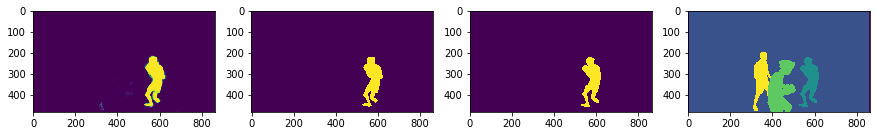

In [53]:
plt.figure(figsize=(15,10))
idx = 3
obj = 1

max_obj = template_msk[idx,0].max().int().data.cpu().numpy()
target_msk_img = self.P2masks(f.relu(target_msk[idx,0] - 1), max_obj - 1)[obj]
template_msk_img = self.P2masks(f.relu(template_msk[idx,0] - 1), max_obj - 1)[obj]
plt.subplot(1,4,1)
plt.imshow(Out_Rs[idx][0,obj-1].detach().cpu().numpy())
plt.subplot(1,4,2)
plt.imshow(target_msk_img.detach().cpu().numpy())
plt.subplot(1,4,3)
plt.imshow(template_msk_img.detach().cpu().numpy())
plt.subplot(1,4,4)
plt.imshow(template_msk[idx,0].detach().cpu().numpy())

In [37]:
(target_msk[idx,0]-Out_Rs[idx][0,0]).norm()

tensor(870.9578, device='cuda:0')

In [43]:
len(msks)

3